# Assignment 9: Final Project
## Computational Methods in Psychology (and Neuroscience)
### Psychology 4500/7559 --- Fall 2020


# Objectives

Upon completion of this assignment, students will have:

1. Described the list generation process in detail
2. Described the experiment details
3. Visualized processed data
4. Performed a statistical analysis to test the hypothesis

# Assignment

Write text (in MarkDown cells) and code (in Code cells) in a Jupyter notebook (after making a copy and renaming it to have your userid in the title --- e.g., A09_Final_Project_mst3k).


## Details

The goal of the final project is to synthesize material covered in the class and produce part of what would go into an actual scientific publication based on *one* of the experiments we ran in the class. Specifically, you will be writing part of the Methods and Results sections.

The basic template is below the code for loading and processing the data. There we outline what each section should include. As always, make sure to label all figures and be sure to refer to the code in the lesson notebooks as a guide for your analyses.

Please feel free to reach out to us on Slack if you have any questions along the way.

* ***When you are done, save this notebook as HTML (`File -> Download as -> HTML`) and upload it to the matching assignment on UVACollab.***  

## General Imports

In [1]:
# import some useful libraries
import numpy as np                # numerical analysis linear algebra
import pandas as pd               # efficient tables
import matplotlib.pyplot as plt   # plotting
import plotnine as pn 
import scipy.stats.distributions as dists     # probability distributions
from scipy import stats
from glob import glob
import os
import arviz as az
import bambi as bmb
import statsmodels.formula.api as smf
import statsmodels.api as sm


from smile.log import log2dl

from ci_within import ci_within

## Custom SLOG loading function

In [2]:
# custom function to load slogs
def load_all_subj_logs(task_dir, log_file):
    # load in a list of all the subj
    subjs = [os.path.split(subj_dir)[-1] 
             for subj_dir in glob(os.path.join(task_dir, 's*'))]
    subjs.sort()

    # loop over subj and their data
    all_dat = []
    for subj in subjs:
        # set the file
        log_path = os.path.join(task_dir, subj, log_file)
        #print(log_path)

        # load the data
        all_dat.extend(log2dl(log_path, subj=subj))

    df = pd.DataFrame(all_dat)
    
    return df

## Load in all the data

In [3]:
# load the data from the word recog task
task_dir = os.path.join('..', 'lessons', 'data', 'Taskapalooza')

df_f = load_all_subj_logs(task_dir, 'log_flanker')
df_i = load_all_subj_logs(task_dir, 'log_image_test')
df_w = load_all_subj_logs(task_dir, 'log_word_test')
df_w.head()

,resp_map_lure,resp_map_target,block_num,trial_num,stim_on_time,stim_on_error,resp,resp_time_time,resp_time_error,rt,...,valence_sd,arousal_mean,arousal_sd,dominance_mean,dominance_sd,word_frequency,novelty,cond,subj,log_num
0,F,J,0,0,234.395511,0.0,J,235.284833,0.000180,0.889323,...,1.5700000000000001,5.3099999999999996,2.23,5.46,2.0499999999999998,3,target,neu,s001,0
1,F,J,0,1,235.885654,0.0,F,237.034670,0.000182,1.149016,...,1.5,4.1200000000000001,1.8300000000000001,5.6600000000000001,1.78,12,lure,neu,s001,0
2,F,J,0,2,237.616869,0.0,F,238.767406,0.000238,1.150537,...,1.8200000000000001,5.4500000000000002,2.1499999999999999,4.6399999999999997,2.0699999999999998,16,lure,neu,s001,0
3,F,J,0,3,239.624933,0.0,F,240.432295,0.000182,0.807362,...,1.24,3.9500000000000002,2.5800000000000001,5.3700000000000001,1.6399999999999999,19,lure,neu,s001,0
4,F,J,0,4,241.432209,0.0,F,242.545227,0.000192,1.113017,...,2.1600000000000001,3.6800000000000002,2.5699999999999998,5.8300000000000001,1.5,49,lure,neu,s001,0


## Some data clean-up

In [4]:
# it turns out the cond is easier to visualize as pure and mixed
def fix_conds(df, type_col):
    # loop over the unique subjects
    usubj = df.subj.unique()
    for s in usubj:
        # loop over their blocks
        ublocks = df.loc[df['subj']==s, 'block_num'].unique()
        for b in ublocks:
            # grab the data for that subj and block
            dfb = df.loc[(df['subj']==s)&(df['block_num']==b)]
            
            # get the unique types in that block
            uval = dfb[type_col].unique()
            if len(uval) > 1:
                # it's mixed
                df.loc[(df['subj']==s)&(df.block_num==b), 'cond'] = 'mixed'
            else:
                # it's the pure
                df.loc[(df['subj']==s)&(df.block_num==b), 'cond'] = 'pure'

# fix the conds in the recog experiments (updated in place)
fix_conds(df_i, type_col='in_out')
fix_conds(df_w, type_col='valence')

# add in log_rt columns
df_f['log_rt'] = np.log(df_f['rt'])
df_i['log_rt'] = np.log(df_i['rt'])
df_w['log_rt'] = np.log(df_w['rt'])

# must make correct an int
df_f['correct'] = df_f['correct'].astype(np.int)
df_i['correct'] = df_i['correct'].astype(np.int)
df_w['correct'] = df_w['correct'].astype(np.int)

# add in a column for whether they made an 'old' response
df_i['old_resp'] = (df_i['resp_map_target'] == df_i['resp']).astype(np.int)
df_w['old_resp'] = (df_w['resp_map_target'] == df_w['resp']).astype(np.int)

# process some of the valence info
df_w['valence_mean'] = df_w['valence_mean'].astype(np.float)
df_w['arousal_mean'] = df_w['arousal_mean'].astype(np.float)
df_w['dominance_mean'] = df_w['dominance_mean'].astype(np.float)
df_w['abs_valence'] = np.abs(df_w['valence_mean'] - 5.0)
df_w['abs_arousal'] = np.abs(df_w['arousal_mean'] - 5.0)

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


# Your text and code goes below here

*All code above should work without modification.*

# Hypothesis

The ability to correctly recognize studied words will increase under conditions in which tested word associations are uniform. Moreover, recognition performance will be better for words of smaller length than that of large length under uniform association.  

# Methods

*This section should read like a methods section of a journal article. Fill in the two sub-sections below.*


## List generation

Word recognition study/test lists were created using the Python programming language in a Jupyter Notebook. The purpose of this list generation was to create a list of words to be studied and pair that with a list of words to be tested. Test sets contained all of the words from its respective study set, as well as an equal number of unstudied words. The experiment pulled words from CSV files of 301, 292, and 208 words with positive, negative, and neutral emotional valences respectively. The words were randomized in order before being read in, after which time they were given descriptive dictionaries that included the key 'valence', paired with values of 'pos', 'neg', and 'neu' depending on the CSV source. Words were also given the key 'novelty', through which cells included in the study period would be marked as a 'target' and unstudied words appearing only in the test would be marked 'lure'. The experiment consisted of four types of study sets; one set with words from each respective valence (key/value pair 'cond':'pure') and a fourth study/test set containing words from all three valences (key/value pair 'cond':'mixed'). There were nine words in each of the pools, with the mixed pool containing three words from each of the valence pools. Each of the studied words were given the key 'novelty' with a value of 'target' since these words were to be ideally recognized by participants during the subsequent testing period. Unstudied words appearing solely in the test list were given a 'novelty' of 'lure'. A total of three study/test blocks were run for each valence. 

List generation used the import of "random", "DictReader", and "copy". 



## SMILE Experiment Details


Presentation of the study/test pairs to subjects was achieved using the State Machine Interface (SMILE) Library through Python in a Jupyter Notebook. A window on the participant's computer would open once the experiment was initiated. Before beginning the trials, participants entered an identifier to allow for collection and analysis of experiment results using the Slog method. SMILE subroutines were used to present each component of the experiment, which began with a subroutine to present instructions of the task. The instructions informed participants that they would begin by studying a list of items and then being asked to discriminate between items that were studied and novel items that were unstudied as fast as possible. Response keys were established and presented to subjects to identify 'target' vs 'lure' words ('target' and 'lure' keys were randomized between subject to be either 'F' or 'J'). Participants were alerted that between each study/test set, they were to solve simple math problems that would appear on screen for 20 seconds. 

Upon clicking "Enter", the screen would empty for 0.5 seconds before asking participants to again click "Enter" to begin the next study block. The screen would again go blank, this time for 2 seconds with a variation of 0.5 seconds, before presenting the set of study words from the study/test pair in the list generation one at a time at the center of the screen. Words would remain on screen for 0.5 seconds with 0.5 second variation before being replaced by the next word. After studying all of the words, the instructions for the math problems would appear instructing participants to indicate if the solution provided was correct or not. Response keys for correct problems coincided with the response for 'target' words. Participants were given a trial problem of each condition before clicking "Enter" to start the math. 

After solving the math problems for 20 seconds (included to avoid active word rehearsal), instructions appeared alerting participants of the start of the test cycle. They were reminded of the key responses and instructed to click "Enter" to start. Subjects would then be presented with one of the words from the respective test list of the study/test pair from the list generation. Only after the stimlus appeared would the system accept key press answers a response. For each tested word, the file would log the response of the subject, current trial, study/test block number, trial number, time of stimulus appearance, response time, and whether or not the response was correct when compared against the 'novelty' of the stimulus. After each response, there would be a wait of 0.5 seconds with 0.5 second variation, followed by the appearance of the next test word. Upon completion of the test, the experiment would again wait 0.5 seconds with 0.5 second variation before returning to the top of the loop to begin the next study/test block. This loop continued to repeat until all of the study/test blocks created in the list generation had been completed. Typical participants took approximately 20 minutes to complete the experiment. 


Experiment presentation used the import of "\*" from "smile.common", "scale" from "smile.scale", "InputSubject" from "smile.startup", ad "MathDistract" from "smile.math_distract" 

# Results

The purpose of the conducted tests was to determine if the conditions under which participants were tested (mixed vs pure) had a significant impact on recognition performance. It was further questioned whether the length of the words studied had an additional effect on the ability to correctly recognize stimuli. These investigations were achieved using condition and categorical word size as initial independent variables. These variables were measured against the mean performance of subjects in the word recognition task, provided as a percent correct out of the total number of words tested. All of the participants maintained recognition performance between 0.79 and 0.86 (range includes error limits). Initial observations of mean performance revealed no variation beyond provided error limits to support the initial claim.

Results were additionally analyzed using a Bayesian Mixed-effects Regression model, in which the word length was treated as a continous variable relying on the number of letters in each word. It was again determined that neither condition nor word length had a significant effect on performance. Statistical models for both of the independent variables were within the observational likelihood for the general recognition studies. Larger experiments with greater participants may shift the results into significance in light of a current skew in intervals. Interestingly, the preliminary trend being observed in regards to number length is opposite of the proposed correlation. The applied Bayesian models suggest the potential for an an increase in test performance as word length is increased. The suggested trend in regards to condition does align with the one proposed. To reiterate, however, none of these results have enough significance to garner substantial claims. The final results of this study refute the proposed claims of a combinatorial effect of word length and testing conditions on recognition performance. 

## Data processing and visualization

*With the lessons as a guide, process your data to create the necessary data frame to plot the visualization associated with the question stated above. Then plot those data.*

In [5]:
# Appends columns to the created list that include
# categorical and continuous word length groups
length = []   # Continuous length given in numbers
size = []     # Categorical size given in "small", "medium", or "large"
for each in df_w['description']:
    length.append(len(each))
    if len(each) >= 3 and len(each) <= 5:
        size.append('small')
    if len(each) >= 6 and len(each) <= 7:
        size.append('medium')
    if len(each) >= 8 and len(each) <= 11:
        size.append('large')
        
    
df_w['num_letters'] = length
df_w['word_size'] = size
df_w.head()

,resp_map_lure,resp_map_target,block_num,trial_num,stim_on_time,stim_on_error,resp,resp_time_time,resp_time_error,rt,...,novelty,cond,subj,log_num,log_rt,old_resp,abs_valence,abs_arousal,num_letters,word_size
0,F,J,0,0,234.395511,0.0,J,235.284833,0.000180,0.889323,...,target,pure,s001,0,-0.117295,1,0.92,0.31,6,medium
1,F,J,0,1,235.885654,0.0,F,237.034670,0.000182,1.149016,...,lure,pure,s001,0,0.138906,0,0.88,0.88,7,medium
2,F,J,0,2,237.616869,0.0,F,238.767406,0.000238,1.150537,...,lure,pure,s001,0,0.140229,0,0.60,0.45,5,small
3,F,J,0,3,239.624933,0.0,F,240.432295,0.000182,0.807362,...,lure,pure,s001,0,-0.213983,0,0.24,1.05,3,small
4,F,J,0,4,241.432209,0.0,F,242.545227,0.000192,1.113017,...,lure,pure,s001,0,0.107075,0,0.95,1.32,4,small


In [6]:
# get the error corrected by condition and whether they said old
res = ci_within(df_w,  
                indexvar='subj',       # column that identifies a subject
                withinvars=['cond', 'word_size'], # list of columns for grouping within subject
                measvar='correct')        # dependent variable averaging over
res

mean       std       sem        ci     len
cond  word_size                                                
mixed large      0.819586  0.415844  0.012749  0.025015  1064.0
      medium     0.826988  0.404550  0.010085  0.019782  1609.0
      small      0.825781  0.410234  0.009826  0.019272  1743.0
pure  large      0.817795  0.408680  0.010176  0.019959  1613.0
      medium     0.835666  0.395029  0.007944  0.015577  2473.0
      small      0.822417  0.404264  0.008025  0.015735  2538.0

In [7]:
res.unstack().reset_index()

cond      mean                           std                      \
word_size            large    medium     small     large    medium     small   
0          mixed  0.819586  0.826988  0.825781  0.415844  0.404550  0.410234   
1           pure  0.817795  0.835666  0.822417  0.408680  0.395029  0.404264   

                sem                            ci                         len  \
word_size     large    medium     small     large    medium     small   large   
0          0.012749  0.010085  0.009826  0.025015  0.019782  0.019272  1064.0   
1          0.010176  0.007944  0.008025  0.019959  0.015577  0.015735  1613.0   

                           
word_size  medium   small  
0          1609.0  1743.0  
1          2473.0  2538.0

In [8]:
res = res.reset_index()
res

,cond,word_size,mean,std,sem,ci,len
0,mixed,large,0.819586,0.415844,0.012749,0.025015,1064.0
1,mixed,medium,0.826988,0.404550,0.010085,0.019782,1609.0
2,mixed,small,0.825781,0.410234,0.009826,0.019272,1743.0
3,pure,large,0.817795,0.408680,0.010176,0.019959,1613.0
4,pure,medium,0.835666,0.395029,0.007944,0.015577,2473.0
5,pure,small,0.822417,0.404264,0.008025,0.015735,2538.0


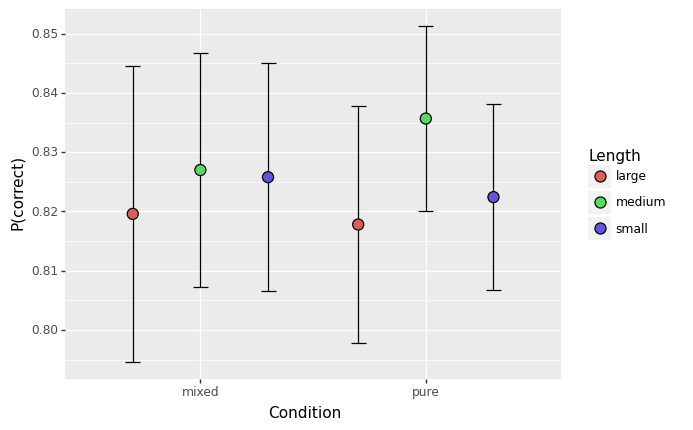

<ggplot: (170558539689)>

In [9]:
p = (pn.ggplot(res, pn.aes('cond','mean', fill='word_size'))
     + pn.geom_errorbar(pn.aes(ymin='mean-ci', ymax='mean+ci', width=0.2), 
                        position=pn.position_dodge(.9))
     + pn.geom_point(position=pn.position_dodge(.9), size=4)
#      + pn.facet_wrap('~novelty')
     + pn.labs(x="Condition", y = "P(correct)", fill='Length')
    )
p

A standard ggplot was used to display the performance of subjects as a function of condition. Performance was displayed as the mean percent of correct responses provided during the testing period for each conditin. Groups were additionally subdivided based on the categorical size of each word stimulus. Words with 3-5 letters were classified as "small", 6-7 letters as "medium", and 9-11 letters as "large". The categorical group distribution was adjusted to accomodate for large variation between words of each number legnth in the current study. Error bars were calculated using confidence intervals of correct performance among subjects. Observation of the error bars shows an initial lack of significance between performance and condition or word size. 

## Statistical test and interpretation

*Perform a statistical test to support your conclusions with regard to your question outlined above. This can be with either statsmodels or with bambi.*

In [10]:
wperf = df_w.groupby(['subj', 'cond', 'word_size', 'novelty'])['correct'].mean()
wperf = wperf.reset_index()
wperf

,subj,cond,word_size,novelty,correct
0,s001,mixed,large,lure,0.952381
1,s001,mixed,large,target,0.807692
2,s001,mixed,medium,lure,0.925000
3,s001,mixed,medium,target,0.857143
4,s001,mixed,small,lure,0.942857
...,...,...,...,...,...
271,s023,pure,large,target,0.700000
272,s023,pure,medium,lure,0.745455
273,s023,pure,medium,target,0.692308
274,s023,pure,small,lure,0.673077


In [11]:
m0 = smf.ols("correct ~ cond * novelty * word_size", wperf).fit()
m0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                correct   R-squared:                       0.164
Model:                            OLS   Adj. R-squared:                  0.129
Method:                 Least Squares   F-statistic:                     4.704
Date:                Tue, 08 Dec 2020   Prob (F-statistic):           1.40e-06
Time:                        21:59:55   Log-Likelihood:                 190.24
No. Observations:                 276   AIC:                            -356.5
Df Residuals:                     264   BIC:                            -313.0
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
======================================================================================================================
                                                         coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------
Intercept                                              0.8739      0.026     33.749      0.000       0.823       0.925
cond[T.pure]                                          -0.0142      0.037     -0.387      0.699      -0.086       0.058
novelty[T.target]                                     -0.1085      0.037     -2.963      0.003      -0.181      -0.036
word_size[T.medium]                                    0.0122      0.037      0.334      0.738      -0.060       0.084
word_size[T.small]                                     0.0239      0.037      0.652      0.515      -0.048       0.096
cond[T.pure]:novelty[T.target]                         0.0238      0.052      0.460      0.646      -0.078       0.126
cond[T.pure]:word_size[T.medium]                      -0.0032      0.052     -0.061      0.951      -0.105       0.099
cond[T.pure]:word_size[T.small]                       -0.0114      0.052     -0.221      0.825      -0.113       0.091
novelty[T.target]:word_size[T.medium]                 -0.0095      0.052     -0.184      0.854      -0.112       0.092
novelty[T.target]:word_size[T.small]                  -0.0363      0.052     -0.701      0.484      -0.138       0.066
cond[T.pure]:novelty[T.target]:word_size[T.medium]     0.0305      0.073      0.416      0.678      -0.114       0.175
cond[T.pure]:novelty[T.target]:word_size[T.small]      0.0185      0.073      0.252      0.801      -0.126       0.163
==============================================================================
Omnibus:                       28.978   Durbin-Watson:                   1.601
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               34.888
Skew:                          -0.815   Prob(JB):                     2.66e-08
Kurtosis:                       3.614   Cond. No.                         25.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [12]:
sm.stats.anova_lm(m0, typ=2)

,sum_sq,df,F,PR(>F)
cond,0.000075,1.0,0.004846,9.445557e-01
novelty,0.741957,1.0,48.109713,3.100126e-11
word_size,0.008665,2.0,0.280942,7.552975e-01
cond:novelty,0.027833,1.0,1.804755,1.802923e-01
cond:word_size,0.002711,2.0,0.087898,9.158810e-01
novelty:word_size,0.014096,2.0,0.456991,6.336857e-01
cond:novelty:word_size,0.002711,2.0,0.087901,9.158786e-01
Residual,4.071460,264.0,NaN,NaN


C:\ProgramData\Anaconda3\lib\site-packages\plotnine\stats\stat_bin.py:93: PlotnineWarning: 'stat_bin()' using 'bins = 45'. Pick better value with 'binwidth'.


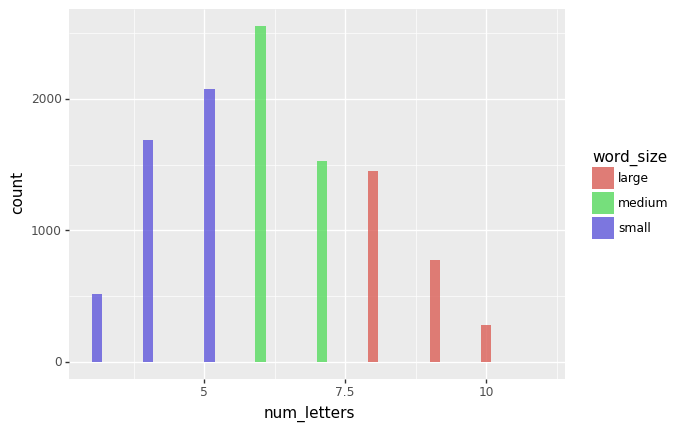

<ggplot: (170559638733)>

In [13]:
# Show the distributions of valence values treating word length as a continous variable
p = (pn.ggplot(df_w, pn.aes('num_letters', fill='word_size'))
     + pn.geom_histogram(alpha=.8)
    )
p

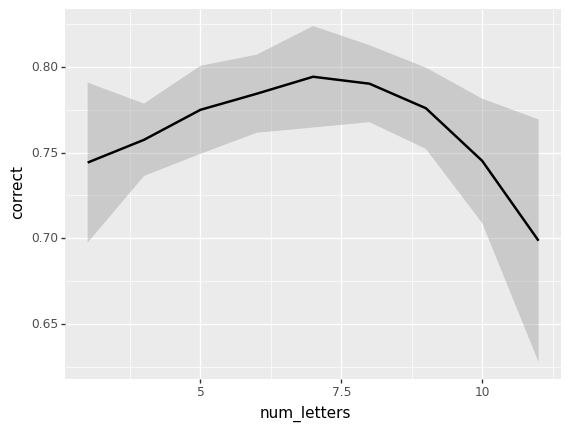

<ggplot: (170561721914)>

In [14]:
p = (pn.ggplot(df_w.loc[df_w['novelty']=='target'], pn.aes('num_letters', 'correct'))
     + pn.geom_smooth(method='loess')
    )
p

In [15]:
# First initialize the model with the data frame we're using
model = bmb.Model(df_w.loc[df_w['novelty']=='target'])

# Next build the regression with both fixed and random effects
results = model.fit('correct ~ cond * num_letters', 
                    random=['1|subj', '1|description'], 
                    family='bernoulli')

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\bambi\models.py:267: UserWarning: Modeling the probability that correct=='1'
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [1|description_offset, 1|description_sd, 1|subj_offset, 1|subj_sd, cond:num_letters, num_letters, cond, Intercept]
INFO:pymc3:NUTS: [1|description_offset, 1|description_sd, 1|subj_offset, 1|subj_sd, cond:num_letters, num_letters, cond, Intercept

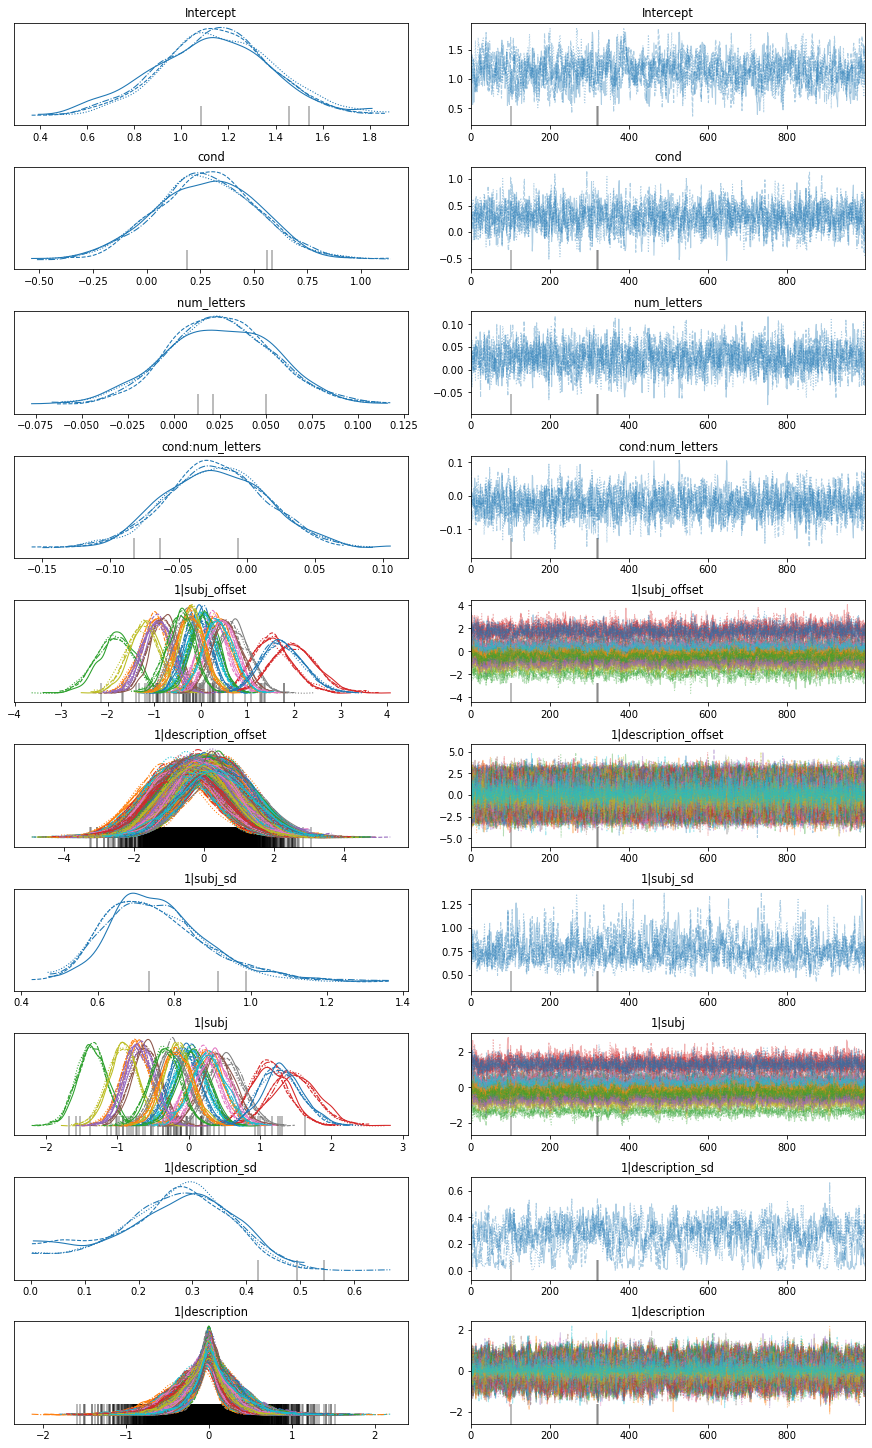

In [16]:
# plot the inference traces for the fit
az.plot_trace(results, compact=True);

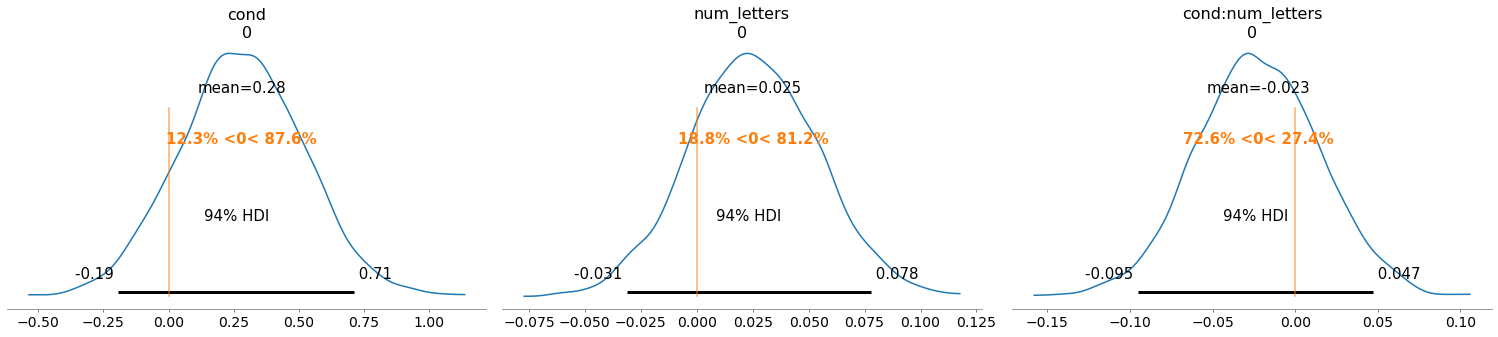

In [17]:
# plot the fixed effect posteriors to examine significance
az.plot_posterior(results, ref_val=0.0, 
                  var_names=['cond', 'num_letters', 'cond:num_letters']);

Word lengths were treated as continous variables ranging from 3 to 11 letters. The first plot displays the fixed effect posterior in regard to the condition of each stimuli to determine if observations fall outside of expected significance ranges for the test. Despite a slight trend in favor of pure conditions, the 94% highest density interval overlaps with zero, indicating a lack of statistical significance between condition and overall performance. The second plot shows the same holds true for the relation between word length and performance. The final plot shows there was no significant interaction between word condition and word length, which conclusively refutes the proposed hypothesis of their combinatorial effect on performance.

# Discussion

***Graduate students only!!!***

*In one to two paragraphs do the following: a) Place the study in the larger literature, summarizing some of the similar work in the field and how this study compares, b) write some analysis of the findings from the study (even if they are null results) and then describe a follow-up study with a new variant of the experiment that you think might help answer further questions on the topic.